# Evaluating Topic Model Dimensionality Reduction: An Experimental Test of LDA vs NMF

Nick Lines

## Imports and environment setup

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)
# from sklearn.pipeline import make_pipeline
#from numpy import array, argsort, tril, zeros
import pickle
import dask
from dask.diagnostics import ProgressBar

In [3]:
from umap import UMAP
import plotly.express as px

In [4]:
from time import time

In [5]:
from dask.distributed import Client
dask_client = Client()

In [6]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.preprocessing import normalize
import pandas as pd
from lda import LDA
import Stemmer
from datasets import load_dataset
import logging

In [7]:
from scipy.optimize import curve_fit

In [8]:
from sklearn.decomposition import IncrementalPCA

In [9]:
from sklearn.metrics import pairwise_distances, pairwise_distances_chunked
from joblib import Parallel, delayed
import numba
from tqdm.autonotebook import tqdm

In [10]:
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import metric_coherence_mimno_2011

In [11]:
from scipy.sparse.linalg import norm as spnorm

In [12]:
from numpy.polynomial.polynomial import Polynomial

In [13]:
DATA_DIR = "../DATA/"

In [14]:
for logger in [logging.getLogger(name) for name in logging.root.manager.loggerDict]:
    logger.setLevel(level=logging.ERROR)

## Some functions we'll use

The following cell of code comes from [Tim Sainburg's](https://timsainburg.com/coranking-matrix-python-numba.html) work to speed up coranking matrix calculations in Python.

In [15]:
def compute_ranking_matrix_parallel(D):
    """ Compute ranking matrix in parallel. Input (D) is distance matrix
    """
    # if data is small, no need for parallel
    if len(D) > 1000:
        n_jobs = -1
    else:
        n_jobs = 1
    r1 = Parallel(n_jobs, prefer="threads")(
            delayed(np.argsort)(i)
            for i in tqdm(D.T, desc = "computing rank matrix", leave=False)
        )
    r2 = Parallel(n_jobs, prefer="threads")(
            delayed(np.argsort)(i)
            for i in tqdm(r1, desc = "computing rank matrix", leave=False)
        )
    # write as a single array
    r2_array = np.zeros((len(r2), len(r2[0])), dtype='int32')
    for i, r2row in enumerate(tqdm(r2, desc="concatenating rank matrix", leave=False)):
        r2_array[i] = r2row
    return r2_array


@numba.njit(fastmath=True)
def populate_Q(Q, i, m, R1, R2):
    """ populate coranking matrix using numba for speed
    """
    for j in range(m):
        k = R1[i, j]
        l = R2[i, j]
        Q[k, l] += 1
    return Q


def iterate_compute_distances(data):
    """ Compute pairwise distance matrix iteratively, so we can see progress
    """
    n = data.shape[0]
    D = np.zeros((n, n), dtype='float32')
    col = 0
    with tqdm(desc="computing pairwise distances", leave=False) as pbar:
        for i, distances in enumerate(
                pairwise_distances_chunked(data, n_jobs=-1),
            ):
            D[col : col + len(distances)] = distances
            col += len(distances)
            if i ==0:
                pbar.total = int(n / len(distances))
            pbar.update(1)
    return D

def compute_coranking_matrix(data_ld, data_hd = None, D_hd = None):
    """ Compute the full coranking matrix
    """
   
    # compute pairwise probabilities
    if D_hd is None:
        D_hd = iterate_compute_distances(data_hd)
    
    D_ld =iterate_compute_distances(data_ld)
    n = len(D_ld)
    # compute the ranking matrix for high and low D
    rm_hd = compute_ranking_matrix_parallel(D_hd)
    rm_ld = compute_ranking_matrix_parallel(D_ld)
    
    # compute coranking matrix from_ranking matrix
    m = len(rm_hd)
    Q = np.zeros(rm_hd.shape, dtype='int16')
    for i in tqdm(range(m), desc="computing coranking matrix"):
        Q = populate_Q(Q,i, m, rm_hd, rm_ld)
        
    Q = Q[1:,1:]
    return Q


@numba.njit(fastmath=True)
def qnx_crm(crm, k):
    """ Average Normalized Agreement Between K-ary Neighborhoods (QNX)
    # QNX measures the degree to which an embedding preserves the local
    # neighborhood around each observation. For a value of K, the K closest
    # neighbors of each observation are retrieved in the input and output space.
    # For each observation, the number of shared neighbors can vary between 0
    # and K. QNX is simply the average value of the number of shared neighbors,
    # normalized by K, so that if the neighborhoods are perfectly preserved, QNX
    # is 1, and if there is no neighborhood preservation, QNX is 0.
    #
    # For a random embedding, the expected value of QNX is approximately
    # K / (N - 1) where N is the number of observations. Using RNX
    # (\code{rnx_crm}) removes this dependency on K and the number of
    # observations.
    #
    # @param crm Co-ranking matrix. Create from a pair of distance matrices with
    # \code{coranking_matrix}.
    # @param k Neighborhood size.
    # @return QNX for \code{k}.
    # @references
    # Lee, J. A., & Verleysen, M. (2009).
    # Quality assessment of dimensionality reduction: Rank-based criteria.
    # \emph{Neurocomputing}, \emph{72(7)}, 1431-1443.

    Python reimplmentation of code by jlmelville
    (https://github.com/jlmelville/quadra/blob/master/R/neighbor.R)
    """
    qnx_crm_sum = np.sum(crm[:k, :k])
    return qnx_crm_sum / (k * len(crm))

@numba.njit(fastmath=True)
def rnx_crm(crm, k):
    """ Rescaled Agreement Between K-ary Neighborhoods (RNX)
    # RNX is a scaled version of QNX which measures the agreement between two
    # embeddings in terms of the shared number of k-nearest neighbors for each
    # observation. RNX gives a value of 1 if the neighbors are all preserved
    # perfectly and a value of 0 for a random embedding.
    #
    # @param crm Co-ranking matrix. Create from a pair of distance matrices with
    # \code{coranking_matrix}.
    # @param k Neighborhood size.
    # @return RNX for \code{k}.
    # @references
    # Lee, J. A., Renard, E., Bernard, G., Dupont, P., & Verleysen, M. (2013).
    # Type 1 and 2 mixtures of Kullback-Leibler divergences as cost functions in
    # dimensionality reduction based on similarity preservation.
    # \emph{Neurocomputing}, \emph{112}, 92-108.

    Python reimplmentation of code by jlmelville
    (https://github.com/jlmelville/quadra/blob/master/R/neighbor.R)
    """
    n = len(crm)
    return ((qnx_crm(crm, k) * (n - 1)) - k) / (n - 1 - k)


#@numba.njit(fastmath=True)
def rnx_auc_crm(crm):
    """ Area Under the RNX Curve 
    # The RNX curve is formed by calculating the \code{rnx_crm} metric for
    # different sizes of neighborhood. Each value of RNX is scaled according to
    # the natural log of the neighborhood size, to give a higher weight to smaller
    # neighborhoods. An AUC of 1 indicates perfect neighborhood preservation, an
    # AUC of 0 is due to random results.
    #
    # param crm Co-ranking matrix.
    # return Area under the curve.
    # references
    # Lee, J. A., Peluffo-Ordo'nez, D. H., & Verleysen, M. (2015).
    # Multi-scale similarities in stochastic neighbour embedding: Reducing
    # dimensionality while preserving both local and global structure.
    # \emph{Neurocomputing}, \emph{169}, 246-261.

    Python reimplmentation of code by jlmelville
    (https://github.com/jlmelville/quadra/blob/master/R/neighbor.R)
    """
    n = len(crm)
    num = 0
    den = 0
    
    qnx_crm_sum = 0
    for k in tqdm(range(1, n - 2)):
        #for k in (range(1, n - 2)):
        qnx_crm_sum += np.sum(crm[(k-1), :k]) + np.sum(crm[:k, (k-1)]) - crm[(k-1), (k-1)]
        qnx_crm = qnx_crm_sum / (k * len(crm))
        rnx_crm = ((qnx_crm * (n - 1)) - k) / (n - 1 - k)
        num += rnx_crm / k
        den += 1 / k
    return num / den

In [16]:
# Override TfidfVectorizer
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc: stemmer.stemWords(analyzer(doc))

For in-depth review of a topic number results:

In [38]:
def run_topic_number(t, n_iter=1500, r =1):
    model_lda = LDA(n_topics=t, n_iter=n_iter, random_state=r)
    for logger in [logging.getLogger(name) for name in logging.root.manager.loggerDict]:
        logger.setLevel(level=logging.ERROR)
    time_lda_start = time()
    lda_document_topic = model_lda.fit_transform(X)
    time_lda_end = time()
    lda_topic_word = model_lda.topic_word_

    # Train NMF
    model_nmf = NMF(n_components=t, init='nndsvda', random_state=r, beta_loss="kullback-leibler", solver="mu", max_iter=(10*n_iter), alpha=0.1, l1_ratio=0.5, tol=1e-4, )
    time_nmf_start = time()
    nmf_document_topic = model_nmf.fit_transform(X)
    time_nmf_end = time()
    nmf_topic_word = model_nmf.components_

    # Train UMAP
    model_umap = UMAP(n_components=t, init='random', random_state=r, )
    time_umap_start = time()
    umap_document_topic = model_umap.fit_transform(X)
    time_umap_end = time()
    # Get DR stats
    Q_umap = compute_coranking_matrix(data_ld=umap_document_topic, data_hd=X)
    Q_lda = compute_coranking_matrix(data_ld=lda_document_topic, data_hd=X)
    Q_nmf = compute_coranking_matrix(data_ld=nmf_document_topic, data_hd=X)

    rnx_auc_crm_lda = rnx_auc_crm(Q_lda)
    rnx_auc_crm_nmf = rnx_auc_crm(Q_nmf)
    rnx_auc_crm_umap = rnx_auc_crm(Q_umap)
    # Get topic stats
    coh_lda = metric_coherence_mimno_2011(lda_topic_word, X)
    coh_nmf = metric_coherence_mimno_2011(nmf_topic_word, X)
    coh_lda.sort()
    coh_nmf.sort()
    mean_coh_lda = coh_lda.mean()
    mean_coh_nmf = coh_nmf.mean()
    # Get reconstruction stats
    recon_error_lda = (norm(X-matmul(lda_document_topic, lda_topic_word))**2) / (spnorm(X)**2)
    recon_error_nmf = norm(X-matmul(nmf_document_topic, nmf_topic_word))**2 / spnorm(X)**2
    title(f"Topic Coherence Scores for {t}-Topic Models [first {n} CNN dailynews articles]")
    plot(coh_lda, "b", label="LDA")
    plot(coh_nmf, "r", label="NMF")
    plot([mean_coh_lda]*t, "b--", label="Mean LDA")
    plot([mean_coh_nmf]*t, "r--", label="Mean NMF")
    legend();
    show()
    print("TOPIC MODELS:")
    n_top_words = 8
    print("   LDA")
    for i, topic_dist in enumerate(lda_topic_word):
        topic_words = array(vocab)[argsort(topic_dist)][:-(n_top_words+1):-1]
        print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    print("   NMF")
    for i, topic_dist in enumerate(nmf_topic_word):
        topic_words = array(vocab)[argsort(topic_dist)][:-(n_top_words+1):-1]
        print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    fig, axs = plt.subplots(figsize=(30,10), ncols = 3)
    axs[0].matshow(np.log(Q_lda+1e-2))
    axs[0].set_title(f'LDA_{t}')
    axs[1].matshow(np.log(Q_nmf+1e-2))
    axs[1].set_title(f'NMF_{t}');
    axs[2].matshow(np.log(Q_umap+1e-2))
    axs[2].set_title(f'UMAP_{t}');
    plt.show()
    print(f"AUC for {t} topics:")
    print("LDA:", rnx_auc_crm_lda)
    print("NMF:", rnx_auc_crm_nmf)
    print("UMAP:", rnx_auc_crm_umap)
    print(f"COHERENCE for {t} topics:")
    print("LDA:", mean_coh_lda)
    print("NMF:", mean_coh_nmf)
    print(f"TRAIN TIME for {t} topics:")
    print("lda_train_time", time_lda_end - time_lda_start)
    print("nmf_train_time", time_nmf_end - time_nmf_start)
    print("umap_train_time", time_umap_end - time_umap_start)
    return(model_lda, model_nmf, model_umap)

For parallelized, fast review and recording.

In [39]:
@dask.delayed
def compute_stats_for_t_topics(t, X, n_iter, r, exp_id):
    """For a given t, compute coherence and AUC for Q matrix
    
    Inputs:
        t: integer number of topics
        X: Document-Word matrix as an array
        n_iter: number of iterations for LDA, NMF
        r: Random seed for reproducibility

    Returns:
    """
    # Train LDA
    model_lda = LDA(n_topics=t, n_iter=n_iter, random_state=r)
    for logger in [logging.getLogger(name) for name in logging.root.manager.loggerDict]:
        logger.setLevel(level=logging.ERROR)
    time_lda_start = time()
    lda_document_topic = model_lda.fit_transform(X)
    time_lda_end = time()
    lda_topic_word = model_lda.topic_word_
    # Train NMF
    model_nmf = NMF(n_components=t, init='nndsvda', random_state=r, beta_loss="kullback-leibler", solver="mu", max_iter=(10*n_iter), alpha=0.1, l1_ratio=0.5, tol=1e-4, )
    time_nmf_start = time()
    nmf_document_topic = model_nmf.fit_transform(X)
    time_nmf_end = time()
    nmf_topic_word = model_nmf.components_
    # Train UMAP
    model_umap = UMAP(n_components=t, init='random', random_state=r, )
    time_umap_start = time()
    umap_document_topic = model_umap.fit_transform(X)
    time_umap_end = time()
    # Get DR stats
    Q_umap = compute_coranking_matrix(data_ld=umap_document_topic, data_hd=X)
    Q_lda = compute_coranking_matrix(data_ld=lda_document_topic, data_hd=X)
    Q_nmf = compute_coranking_matrix(data_ld=nmf_document_topic, data_hd=X)
    rnx_auc_crm_lda = rnx_auc_crm(Q_lda)
    rnx_auc_crm_nmf = rnx_auc_crm(Q_nmf)
    rnx_auc_crm_umap = rnx_auc_crm(Q_umap)
    # Get topic stats
    coh_lda = metric_coherence_mimno_2011(lda_topic_word, X)
    coh_nmf = metric_coherence_mimno_2011(nmf_topic_word, X)
    coh_lda.sort()
    coh_nmf.sort()
    mean_coh_lda = coh_lda.mean()
    mean_coh_nmf = coh_nmf.mean()
    # Get reconstruction stats
    recon_error_lda = (norm(X-matmul(lda_document_topic, lda_topic_word))**2) / (spnorm(X)**2)
    recon_error_nmf = norm(X-matmul(nmf_document_topic, nmf_topic_word))**2 / spnorm(X)**2
    with mlflow.start_run(experiment_id=exp_id):
        mlflow.log_param("number_of_topics", t)
        mlflow.log_metric("lda_train_time", time_lda_end - time_lda_start)
        mlflow.log_metric("nmf_train_time", time_nmf_end - time_nmf_start)
        mlflow.log_metric("umap_train_time", time_umap_end - time_umap_start)
        mlflow.log_metric("rnx_auc_crm_lda", rnx_auc_crm_lda)
        mlflow.log_metric("rnx_auc_crm_nmf", rnx_auc_crm_nmf)
        mlflow.log_metric("rnx_auc_crm_umap", rnx_auc_crm_umap)
        mlflow.log_metric("mean_coh_lda", mean_coh_lda)
        mlflow.log_metric("mean_coh_nmf", mean_coh_nmf)
        mlflow.log_metric("recon_error_lda", recon_error_lda)
        mlflow.log_metric("recon_error_nmf", recon_error_nmf)
    mlflow.end_run()

## Prepare the data

For this experiment we'll use the first 2k documents in the popular CNN Daily Mail dataset.

In [19]:
n = 2000
n_filename = DATA_DIR + f"/CNN_articles_first_{n}.pkl"
if not os.path.exists(n_filename):
    dataset = load_dataset("cnn_dailymail", '3.0.0')
    data_n = dataset["train"]['article'][:n]
    with open(n_filename, "wb") as outfile:
        pickle.dump(data_n, outfile)
else:
    with open(n_filename, "rb") as infile:
        data_n = pickle.load(infile)

To produce the document-word matrix, we'll use a vocabulary vectorizer.

In [20]:
matrix_filename = DATA_DIR + f"/CNN_{n}_doc_word_matrix_and_vocab.pkl"
if not os.path.exists(matrix_filename):
    stemmer = Stemmer.Stemmer('en')
    analyzer = CountVectorizer().build_analyzer()
    vectorizer = StemmedCountVectorizer(stop_words='english', min_df=5, max_df=0.5)
    X = vectorizer.fit_transform(data_n)  
    vocab = vectorizer.get_feature_names()
    with open(matrix_filename, "wb") as picklefile:
        pickle.dump([X, vocab], picklefile)
else:
    with open(matrix_filename, "rb") as picklefile:
        X, vocab = pickle.load(picklefile)

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [33]:
X[0].toarray().sum()

771

Some scientists choose the number of topics by finding the elbow in a PCA explained variance plot.

In [21]:
transformer = IncrementalPCA(n_components=None)
transformer.fit(X)

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IncrementalPCA()

Since the explained variance curve is noisy, we'll find the elbow by smoothing with a degree 8 polynomial first, then taking the second derivative's first zero.

In [22]:
P8_fit = Polynomial.fit(x=list(range(50)), y=transformer.explained_variance_[:50], deg=8)

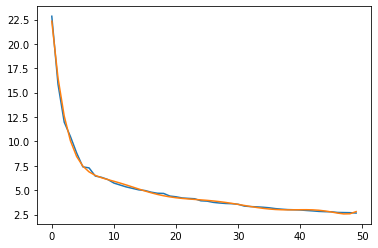

In [23]:
plot(transformer.explained_variance_[:50]);
plot(range(50), P8_fit(range(50)));

In [24]:
print(f"A good guess for the right number of topics is {int(P8_fit.deriv().deriv().roots().min())}")

A good guess for the right number of topics is 9


computing pairwise distances: 0it [00:00, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1996 [00:00<?, ?it/s]

  0%|          | 0/1996 [00:00<?, ?it/s]

  0%|          | 0/1996 [00:00<?, ?it/s]

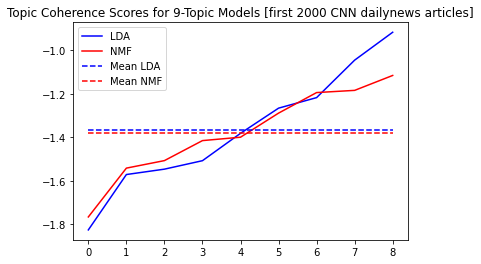

TOPIC MODELS:
   LDA
Topic 0: polic told offic court case investig charg accord
Topic 1: like just know think work make day want
Topic 2: attack govern militari forc al state secur countri
Topic 3: china countri world govern south chines north korea
Topic 4: use new million compani busi make like site
Topic 5: game team player play world win second match
Topic 6: health school student children food women care help
Topic 7: citi water area flight plane offici airport accord
Topic 8: presid obama state american republican elect democrat hous
   NMF
Topic 0: like just think work know make new day
Topic 1: govern attack militari forc al countri kill group
Topic 2: obama presid republican elect democrat hous state american
Topic 3: polic told court offic investig charg case famili
Topic 4: compani million new use china world like 000
Topic 5: flight citi plane water offici home area airport
Topic 6: game team world player play win second sport
Topic 7: state student school iran north korea 

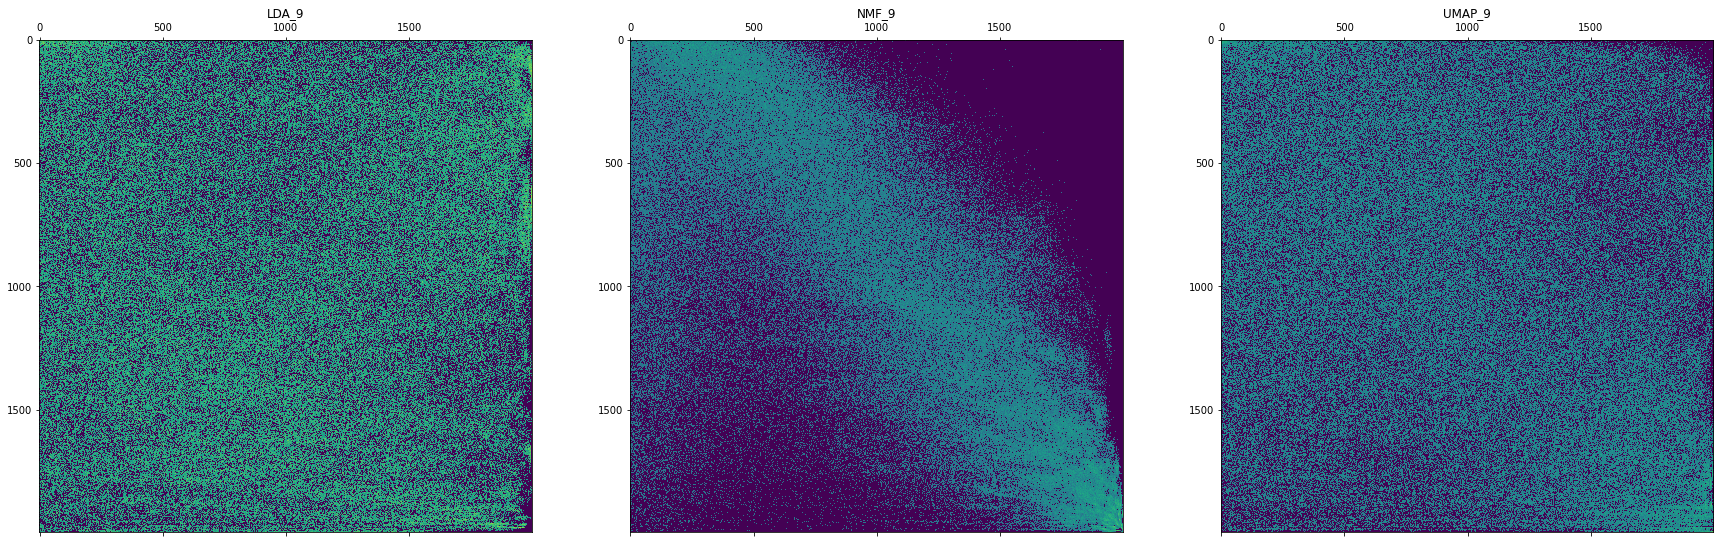

AUC for 9 topics:
LDA: 0.02025487260467249
NMF: 0.14178167802131972
UMAP: 0.12256829403518045
COHERENCE for 9 topics:
LDA: -1.3645319110333605
NMF: -1.3794562654493099
TRAIN TIME for 9 topics:
lda_train_time 94.66453742980957
nmf_train_time 11.204476118087769
umap_train_time 8.251998901367188


In [40]:
results_9 = run_topic_number(t=9)

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


computing pairwise distances: 0it [00:00, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1996 [00:00<?, ?it/s]

  0%|          | 0/1996 [00:00<?, ?it/s]

  0%|          | 0/1996 [00:00<?, ?it/s]

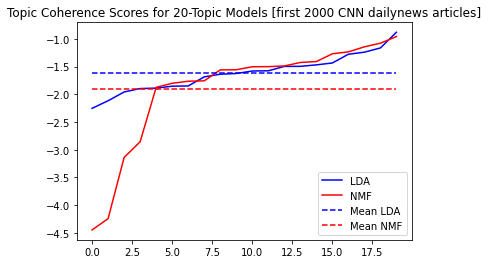

TOPIC MODELS:
   LDA
Topic 0: govern syria iran protest countri state syrian isi
Topic 1: game player team win play second world match
Topic 2: court case charg attorney alleg prison judg trial
Topic 3: use twitter facebook site user phone new video
Topic 4: china chines north korea south korean kong hong
Topic 5: london british world european europ race itali germani
Topic 6: women right immigr law state men girl american
Topic 7: citi state storm mexico nation water area home
Topic 8: countri children oil help 000 nation africa african
Topic 9: film movi star music game play book new
Topic 10: health care medic patient hospit doctor cancer drug
Topic 11: school student univers colleg educ american state news
Topic 12: attack militari forc kill al iraq secur afghanistan
Topic 13: obama presid republican democrat elect vote hous senat
Topic 14: like just make want think know don work
Topic 15: flight plane airport ship airlin passeng travel search
Topic 16: polic famili told offic kill

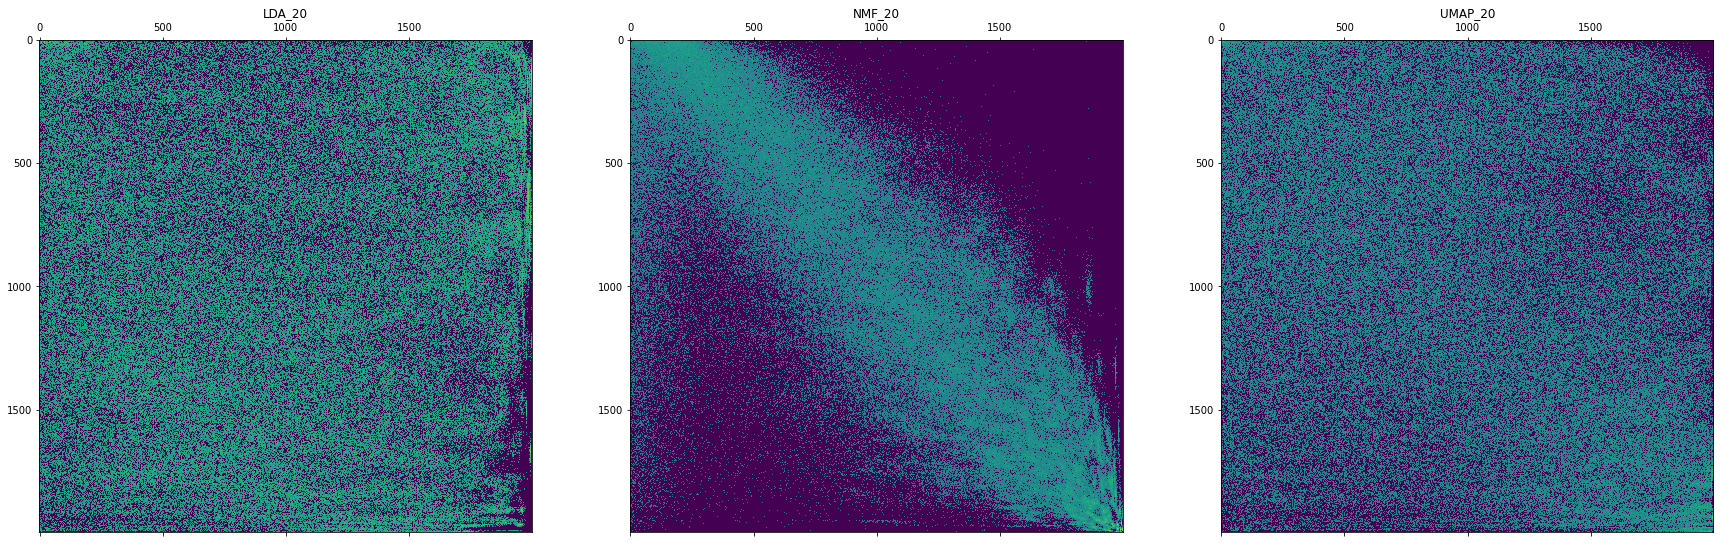

AUC for 20 topics:
LDA: 0.021217238179449264
NMF: 0.2046162909587649
UMAP: 0.1274739853209719
COHERENCE for 20 topics:
LDA: -1.6197517984044107
NMF: -1.9014389771311464
TRAIN TIME for 20 topics:
lda_train_time 188.49499201774597
nmf_train_time 13.00613021850586
umap_train_time 9.471200942993164


In [41]:
results_20 = run_topic_number(t=20)

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


computing pairwise distances: 0it [00:00, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing pairwise distances: 0it [00:00, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

concatenating rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1996 [00:00<?, ?it/s]

  0%|          | 0/1996 [00:00<?, ?it/s]

  0%|          | 0/1996 [00:00<?, ?it/s]

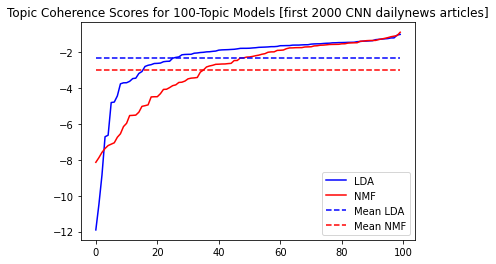

TOPIC MODELS:
   LDA
Topic 0: syria syrian turkey al saudi assad opposit regim
Topic 1: american king black word support america right african
Topic 2: health patient hospit doctor medic cancer diseas case
Topic 3: israel isra palestinian hama gaza east jerusalem state
Topic 4: new york citi jersey offic street place mayor
Topic 5: told statement did home releas plan steven work
Topic 6: school student univers educ colleg high state class
Topic 7: help need organ aid fund donat countri children
Topic 8: like dress room look metal design white love
Topic 9: secur depart govern use inform offici intellig program
Topic 10: use technolog design world develop stage work engin
Topic 11: facebook twitter post site onlin social user internet
Topic 12: al iraq isi qaeda group iraqi milit terrorist
Topic 13: club leagu team footbal player cup play season
Topic 14: compani industri world countri market product new busi
Topic 15: drug state abort use fda compani agenc approv
Topic 16: africa south

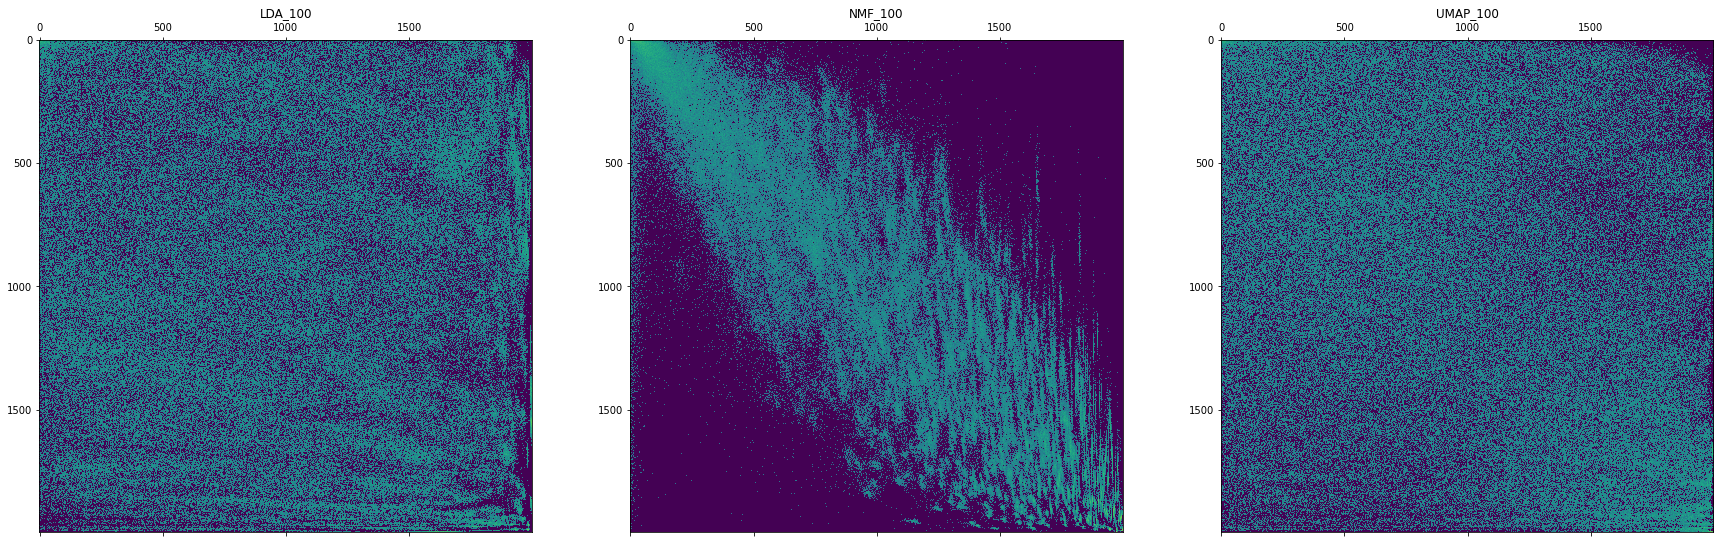

AUC for 100 topics:
LDA: 0.05608407955156655
NMF: 0.3335999812253175
UMAP: 0.12728143523048221
COHERENCE for 100 topics:
LDA: -2.345785081725543
NMF: -3.000165792797082
TRAIN TIME for 100 topics:
lda_train_time 829.860044002533
nmf_train_time 41.697198152542114
umap_train_time 21.99396276473999


In [42]:
results_100 = run_topic_number(t=100)

Now run these stats over number of topic choices and all three DR techniques using Dask and MFLOW.

In [43]:
exp_name = "topic_DR_stats_2"
mlflow.set_experiment(exp_name)
mlclient = MlflowClient()
exp_id = mlclient.get_experiment_by_name(exp_name).experiment_id

INFO: 'topic_DR_stats_2' does not exist. Creating a new experiment


In [44]:
dask_client.scatter(X)

<Future: finished, type: scipy.sparse.csr.csr_matrix, key: csr_matrix-651e0d45bfe73b56b4d07272c6eee1dd>

In [45]:
t_values = list(range(2,201))
jobs = [compute_stats_for_t_topics(t, X, n_iter, r, exp_id) for t in t_values]

In [46]:
with ProgressBar():
    results = dask.compute(*jobs)

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/distributed/worker.py:4156: UserWarning: Large object of size 4.52 MiB detected in task graph: 
  (200, <2000x8533 sparse matrix of type '<class 'nu ... , 1500, 1, '3')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107.

computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
compu

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwis

computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
compu

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:


computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
compu

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:142

computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
compu

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:142

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwis

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:142

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:142

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:


computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:142

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pai

computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
compu

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_

computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
compu

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:142

computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
compu

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:


computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
compu

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwis

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:


computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py

  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pai

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_

  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pai

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:


  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pai

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwis

  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pai

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwis

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.

  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pai

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:142

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:142

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.

  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pai

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:142

computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
compu

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.

  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pai

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:142

  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pai

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_

  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pai

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:142

computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
compu

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py

computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
compu

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwis

computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
compu

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.

  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing rank matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwi

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:142

  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pai

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:142

  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pai

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1

computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
  0%|          | 0/1996 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [00:00<?, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing pairwise distances: 0it [00:00, ?it/s]
computing coranking matrix:   0%|          | 0/2000 [0

/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1424: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  if effective_n_jobs(n_jobs) == 1:
/home/ubuntu/anaconda3/envs/tmdr/lib/python3.9/site-packages/sklearn/metrics/pairwis